## 0. Environment & Dependencies

Import all required libraries for data prep, modeling, and evaluation, plus RANDOM_STATE/TOPK_RATIO for reproducible baselines.


In [2]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    brier_score_loss,
)

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

RANDOM_STATE = 42
TOPK_RATIO = 0.1


## 1. Load Data

Read the cleaned churn dataset and quickly inspect the head for sanity.


In [3]:
DATA_PATH = Path('churn_clean.csv')
assert DATA_PATH.exists(), f"Data file not found: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2. Prepare Features & Target

Drop the target column from features, store `Exited` as labels, and capture categorical/numeric column lists for preprocessing.


In [4]:
X = df.drop('Exited', axis=1)
y = df['Exited']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols, num_cols


(['Geography', 'Gender'],
 ['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'])

## 3. Metric Helpers

Top-K precision/recall plus an evaluation wrapper shared across models for consistent reporting.


In [5]:
def topk_precision_recall(y_true, y_proba, k_ratio: float = TOPK_RATIO):
    """Compute Precision@K and Recall@K."""
    assert 0 < k_ratio <= 1, 'k_ratio must be in (0, 1].'
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)

    n = len(y_true)
    k = max(1, int(np.floor(n * k_ratio)))
    order = np.argsort(-y_proba)
    topk_idx = order[:k]

    y_topk = y_true[topk_idx]
    tp_at_k = y_topk.sum()
    total_pos = y_true.sum()

    precision_at_k = tp_at_k / k
    recall_at_k = tp_at_k / total_pos if total_pos > 0 else 0.0

    return {
        'K': k,
        'Precision@K': precision_at_k,
        'Recall@K': recall_at_k,
    }


def evaluate_classifier(y_true, y_proba, threshold: float = 0.5, k_ratio: float = TOPK_RATIO):
    """Return ROC-AUC, PR-AUC, F1, Balanced Accuracy, Brier Score, Precision@K/Recall@K."""
    y_true_arr = y_true.values if hasattr(y_true, 'values') else np.asarray(y_true)
    y_proba_arr = np.asarray(y_proba)
    y_pred = (y_proba_arr >= threshold).astype(int)

    metrics = {
        'ROC-AUC': roc_auc_score(y_true_arr, y_proba_arr),
        'PR-AUC': average_precision_score(y_true_arr, y_proba_arr),
        'F1': f1_score(y_true_arr, y_pred),
        'BalancedAccuracy': balanced_accuracy_score(y_true_arr, y_pred),
        'BrierScore': brier_score_loss(y_true_arr, y_proba_arr),
    }

    topk = topk_precision_recall(y_true_arr, y_proba_arr, k_ratio=k_ratio)
    metrics.update(topk)
    return metrics


## 4. 60/20/20 Split

Use a two-step stratified split to keep class balance consistent across train/validation/test.


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=RANDOM_STATE,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print('Train:', X_train.shape, 'Target ratio:', y_train.mean().round(3))
print('Validation:', X_val.shape, 'Target ratio:', y_val.mean().round(3))
print('Test:', X_test.shape, 'Target ratio:', y_test.mean().round(3))


Train: (6000, 10) Target ratio: 0.204
Validation: (2000, 10) Target ratio: 0.204
Test: (2000, 10) Target ratio: 0.204


## 5. Preprocessing & Decision Tree Pipeline

One-hot encode categorical features, standardize numeric ones, then fit a class-balanced depth-limited tree.


In [7]:
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer([
    ('categorical', ohe, cat_cols),
    ('numeric', StandardScaler(), num_cols)
])

tree_params = dict(
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=RANDOM_STATE,
)

tree_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', DecisionTreeClassifier(**tree_params))
])
tree_pipeline


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 6. Train The Decision Tree

Fit the pipeline on the training split so we can reuse it for evaluation or deployment.


In [8]:
tree_pipeline.fit(X_train, y_train)
tree_pipeline


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categorical', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7. Generate Validation/Test Predictions

Collect class predictions and probabilities for downstream metrics and plots.


In [9]:
predictions = {}
for dataset_name, (X_split, y_split) in {
    'Validation': (X_val, y_val),
    'Test': (X_test, y_test),
}.items():
    y_pred = tree_pipeline.predict(X_split)
    y_proba = tree_pipeline.predict_proba(X_split)[:, 1]
    predictions[dataset_name] = {
        'y_true': y_split,
        'y_pred': y_pred,
        'y_proba': y_proba,
    }

predictions


{'Validation': {'y_true': 8583    0
  1924    0
  3195    0
  5263    0
  1484    0
         ..
  926     0
  6727    1
  4745    1
  1307    0
  7464    1
  Name: Exited, Length: 2000, dtype: int64,
  'y_pred': array([0, 1, 0, ..., 1, 1, 1], shape=(2000,)),
  'y_proba': array([0.40000453, 0.54564528, 0.0687047 , ..., 0.93990361, 0.83691717,
         0.67358689], shape=(2000,))},
 'Test': {'y_true': 9167    0
  9387    0
  6859    0
  3500    0
  6233    0
         ..
  7392    0
  3233    0
  218     1
  4755    0
  7634    0
  Name: Exited, Length: 2000, dtype: int64,
  'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(2000,)),
  'y_proba': array([0.28109189, 0.26968717, 0.40000453, ..., 0.        , 0.48410956,
         0.31506759], shape=(2000,))}}

## 8. Aggregate Key Metrics

Summarize ROC-AUC, PR-AUC, F1, Balanced Accuracy, Brier Score, and Top-K stats into a tidy DataFrame.


In [10]:
metrics_rows = []
for dataset_name, values in predictions.items():
    metrics = evaluate_classifier(values['y_true'], values['y_proba'], k_ratio=TOPK_RATIO)
    metrics_rows.append({'Dataset': dataset_name, **metrics})

metrics_df = pd.DataFrame(metrics_rows)
metrics_df


,Dataset,ROC-AUC,PR-AUC,F1,BalancedAccuracy,BrierScore,K,Precision@K,Recall@K
0,Validation,0.837913,0.635243,0.573727,0.770895,0.157288,200,0.805,0.394608
1,Test,0.822026,0.634426,0.562963,0.757645,0.158332,200,0.810,0.398034


## 9. Classification Reports & Confusion Matrices

Print detailed reports and keep confusion matrices for visualization.


In [11]:
conf_matrices = {}
for dataset_name, values in predictions.items():
    cm = confusion_matrix(values['y_true'], values['y_pred'])
    conf_matrices[dataset_name] = cm
    print(f"Decision Tree - {dataset_name} classification report")
    print(classification_report(values['y_true'], values['y_pred']))

conf_matrices


Decision Tree - Validation classification report
              precision    recall  f1-score   support

           0       0.93      0.76      0.83      1592
           1       0.45      0.79      0.57       408

    accuracy                           0.76      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.83      0.76      0.78      2000

Decision Tree - Test classification report
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1593
           1       0.45      0.75      0.56       407

    accuracy                           0.76      2000
   macro avg       0.69      0.76      0.70      2000
weighted avg       0.83      0.76      0.78      2000



{'Validation': array([[1202,  390],
        [  87,  321]]),
 'Test': array([[1224,  369],
        [ 103,  304]])}

## 10. Figure Output Directory

Ensure the shared figures folder exists before saving plots.


In [12]:
FIG_DIR = Path('figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)


## 11. Compute ROC/PR Curve Data

Store FPR/TPR and Precision/Recall arrays for plotting.


In [13]:
curve_data = {}
for dataset_name, values in predictions.items():
    fpr, tpr, _ = roc_curve(values['y_true'], values['y_proba'])
    prec, rec, _ = precision_recall_curve(values['y_true'], values['y_proba'])
    auc = roc_auc_score(values['y_true'], values['y_proba'])
    ap = average_precision_score(values['y_true'], values['y_proba'])
    curve_data[dataset_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'precision': prec,
        'recall': rec,
        'auc': auc,
        'ap': ap,
    }
curve_data


{'Validation': {'fpr': array([0.        , 0.00753769, 0.00879397, 0.00942211, 0.00942211,
         0.01005025, 0.01067839, 0.01130653, 0.01130653, 0.01319095,
         0.01633166, 0.01633166, 0.0169598 , 0.01758794, 0.01884422,
         0.02638191, 0.02638191, 0.02763819, 0.03140704, 0.03768844,
         0.03957286, 0.04334171, 0.04396985, 0.04962312, 0.04962312,
         0.05276382, 0.06155779, 0.06658291, 0.07286432, 0.07851759,
         0.07914573, 0.08291457, 0.11180905, 0.13442211, 0.13693467,
         0.14258794, 0.14447236, 0.15829146, 0.16394472, 0.16582915,
         0.17148241, 0.17336683, 0.1790201 , 0.1928392 , 0.1928392 ,
         0.22675879, 0.22864322, 0.23806533, 0.24497487, 0.24748744,
         0.25502513, 0.25565327, 0.25690955, 0.2638191 , 0.26570352,
         0.26758794, 0.27386935, 0.31909548, 0.32914573, 0.33856784,
         0.34610553, 0.36997487, 0.37625628, 0.38693467, 0.39007538,
         0.3919598 , 0.39321608, 0.46670854, 0.46733668, 0.48680905,
         0.48

## 12. Plot ROC Curves

Overlay validation and test ROC curves to compare generalization.


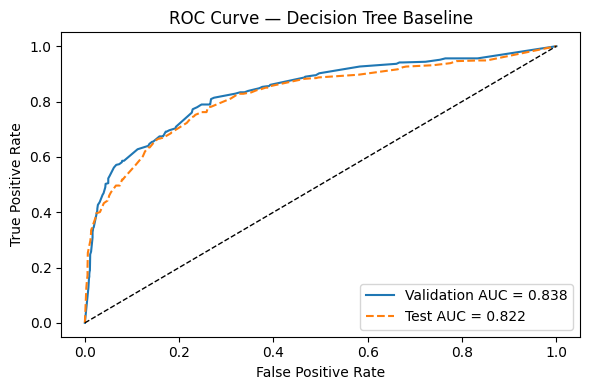

In [14]:
plt.figure(figsize=(6, 4))
for dataset_name, roc_info in curve_data.items():
    linestyle = '-' if dataset_name == 'Validation' else '--'
    plt.plot(roc_info['fpr'], roc_info['tpr'], linestyle=linestyle, label=f"{dataset_name} AUC = {roc_info['auc']:.3f}")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Decision Tree Baseline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve_tree_baseline.png', dpi=200)
plt.show()


## 13. Plot Precision-Recall Curves

Visualize the recall–precision trade-off for validation vs. test.


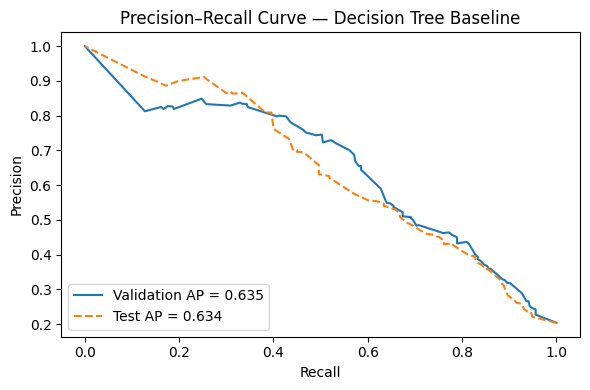

In [15]:
plt.figure(figsize=(6, 4))
for dataset_name, pr_info in curve_data.items():
    linestyle = '-' if dataset_name == 'Validation' else '--'
    plt.plot(pr_info['recall'], pr_info['precision'], linestyle=linestyle, label=f"{dataset_name} AP = {pr_info['ap']:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve — Decision Tree Baseline')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(FIG_DIR / 'pr_curve_tree_baseline.png', dpi=200)
plt.show()


## 14. Plot Confusion Matrices

Heatmaps of validation and test confusion matrices for quick error inspection.


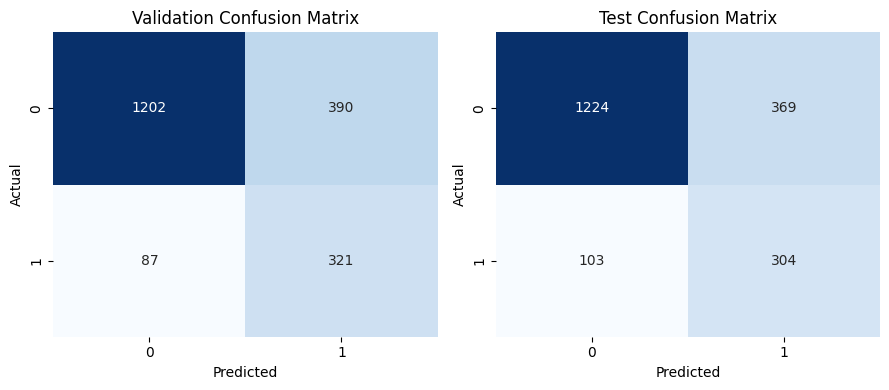

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for ax, dataset_name in zip(axes, ['Validation', 'Test']):
    sns.heatmap(conf_matrices[dataset_name], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f'{dataset_name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrices_tree_baseline.png', dpi=200)
plt.show()


## 15. Feature Importances

Review the top features driving the depth-limited tree.


In [17]:
model = tree_pipeline.named_steps['model']
feature_names = tree_pipeline.named_steps['preprocess'].get_feature_names_out()
importances = pd.Series(model.feature_importances_, index=feature_names)
top_features = importances.sort_values(ascending=False).head(20)
top_features


numeric__Age                      0.404206
numeric__NumOfProducts            0.258803
numeric__Balance                  0.126966
numeric__IsActiveMember           0.066553
categorical__Geography_Germany    0.044846
numeric__CreditScore              0.037889
numeric__EstimatedSalary          0.028245
numeric__Tenure                   0.018246
categorical__Gender_Female        0.008107
categorical__Gender_Male          0.003426
numeric__HasCrCard                0.001602
categorical__Geography_France     0.001113
categorical__Geography_Spain      0.000000
dtype: float64

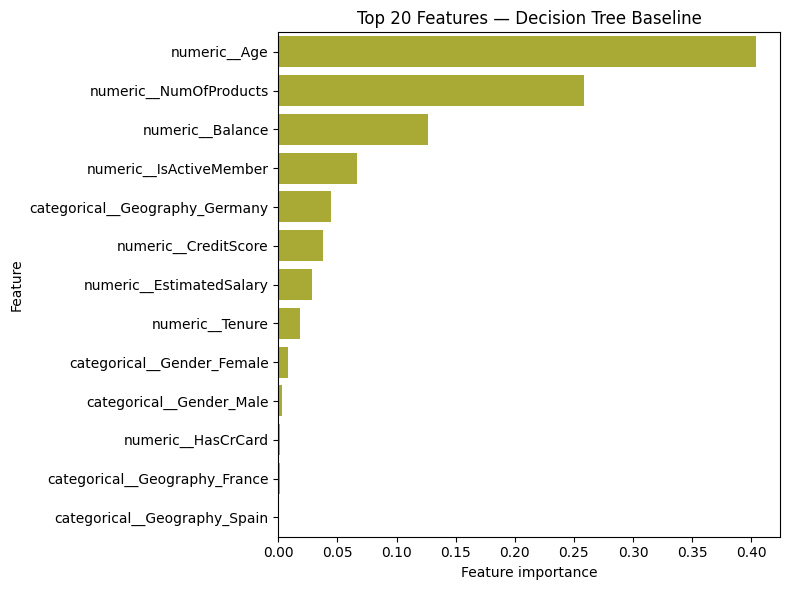

In [18]:
plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, color='tab:olive')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Top 20 Features — Decision Tree Baseline')
plt.tight_layout()
plt.show()


## 16. Export Metrics & Predictions

Persist the summary metrics and per-sample probabilities for downstream comparison.


In [19]:
OUTPUT_DIR = Path('reports')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

metrics_df.to_csv(OUTPUT_DIR / 'decision_tree_metrics_en.csv', index=False)

pred_rows = []
for dataset_name, values in predictions.items():
    pred_rows.append(pd.DataFrame({
        'dataset': dataset_name,
        'y_true': values['y_true'].values,
        'y_proba': values['y_proba'],
    }))
pred_df = pd.concat(pred_rows, ignore_index=True)
pred_df.to_csv(OUTPUT_DIR / 'decision_tree_predictions_en.csv', index=False)

print('Saved metrics and predictions to', OUTPUT_DIR)


Saved metrics and predictions to reports


## 17. Persist The Trained Pipeline

Save the full tree pipeline as joblib so it can be reloaded without retraining.


In [20]:
MODEL_DIR = Path('models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / 'decision_tree_baseline.joblib'
joblib.dump(tree_pipeline, MODEL_PATH)
MODEL_PATH


PosixPath('models/decision_tree_baseline.joblib')